# SimHash改善: 超平面生成戦略の比較実験

## 目的

狭いコーン分布（高コサイン類似度が密集）に適した超平面生成戦略を探索する。

**比較対象:**
1. **Random**: 標準 N(0,1) ランダム超平面（ベースライン）
2. **Orthogonal**: QR分解で直交化した超平面（BOLSH風）
3. **DataSampled**: データの差分ベクトルから生成した超平面

**評価指標:**
- ハミング距離とコサイン類似度の相関係数
- Recall@10（候補数200件、1000件での再現率）
- Multi-Probe効果

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

from src.lsh import (
    SimHashGenerator, 
    hamming_distance,
    generate_multiprobe_hashes
)

## 1. データの読み込み

In [3]:
# e5-large のエンベディングを使用（狭いコーン分布）
df = pd.read_parquet('../data/embeddings_e5_large.parquet')
embeddings = np.stack(df['vector'].values).astype(np.float32)
texts = df['text'].tolist()

print(f'データ数: {len(embeddings):,}')
print(f'次元数: {embeddings.shape[1]}')

# コサイン類似度の分布を確認
sample_idx = np.random.default_rng(42).choice(len(embeddings), 1000, replace=False)
sample = embeddings[sample_idx]
cos_sims = sample @ sample.T
upper_tri = cos_sims[np.triu_indices_from(cos_sims, k=1)]

print(f'\nコサイン類似度分布:')
print(f'  平均: {np.mean(upper_tri):.4f}')
print(f'  標準偏差: {np.std(upper_tri):.4f}')
print(f'  範囲: [{np.min(upper_tri):.4f}, {np.max(upper_tri):.4f}]')

データ数: 10,000
次元数: 1024

コサイン類似度分布:
  平均: 0.7726
  標準偏差: 0.0291
  範囲: [0.6555, 0.9844]


## 2. 各戦略のSimHashGeneratorを作成

In [4]:
# 各戦略でSimHashGeneratorを作成
strategies = ['random', 'orthogonal', 'data_sampled']
generators = {}

for strategy in strategies:
    gen = SimHashGenerator(
        dim=embeddings.shape[1],
        hash_bits=128,
        seed=42,
        strategy=strategy
    )
    
    if strategy == 'data_sampled':
        # データサンプル戦略はfit_data()が必要
        gen.fit_data(embeddings)
    
    generators[strategy] = gen
    print(f'{strategy}: hyperplanes shape = {gen.hyperplanes.shape}')

random: hyperplanes shape = (128, 1024)
orthogonal: hyperplanes shape = (128, 1024)
data_sampled: hyperplanes shape = (128, 1024)


## 3. 全ドキュメントのハッシュを計算

In [5]:
# 各戦略でハッシュを計算
hashes = {}

for strategy, gen in generators.items():
    print(f'{strategy}: ハッシュ計算中...')
    hashes[strategy] = gen.hash_batch(embeddings)
    print(f'  完了: {len(hashes[strategy])} 件')

random: ハッシュ計算中...
  完了: 10000 件
orthogonal: ハッシュ計算中...
  完了: 10000 件
data_sampled: ハッシュ計算中...
  完了: 10000 件


## 4. ハミング距離とコサイン類似度の相関分析

In [6]:
def compute_correlation(embeddings, hash_list, num_samples=5000, seed=42):
    """ランダムペアでハミング距離とコサイン類似度の相関を計算"""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    ham_distances = []
    cos_similarities = []
    
    for _ in range(num_samples):
        i, j = rng.choice(n, 2, replace=False)
        
        # ハミング距離
        ham = hamming_distance(hash_list[i], hash_list[j])
        ham_distances.append(ham)
        
        # コサイン類似度
        cos = np.dot(embeddings[i], embeddings[j])
        cos_similarities.append(cos)
    
    # ピアソン相関とスピアマン相関
    pearson_r, _ = pearsonr(ham_distances, cos_similarities)
    spearman_r, _ = spearmanr(ham_distances, cos_similarities)
    
    return {
        'pearson': pearson_r,
        'spearman': spearman_r,
        'ham_mean': np.mean(ham_distances),
        'ham_std': np.std(ham_distances),
    }

In [7]:
# 各戦略で相関を計算
print('=' * 80)
print('              ハミング距離 vs コサイン類似度 相関分析')
print('=' * 80)

correlation_results = {}

for strategy in strategies:
    result = compute_correlation(embeddings, hashes[strategy])
    correlation_results[strategy] = result
    
    print(f'\n{strategy.upper()}:')
    print(f'  ピアソン相関:   {result["pearson"]:.4f}')
    print(f'  スピアマン相関: {result["spearman"]:.4f}')
    print(f'  ハミング距離:   平均={result["ham_mean"]:.1f}, 標準偏差={result["ham_std"]:.2f}')

# 比較表
print('\n' + '=' * 80)
print('                         相関係数比較')
print('=' * 80)
print(f'{"戦略":20} | {"ピアソン":>10} | {"スピアマン":>10} | {"改善率":>10}')
print('-' * 60)

baseline = correlation_results['random']['pearson']
for strategy in strategies:
    r = correlation_results[strategy]
    improvement = (r['pearson'] - baseline) / abs(baseline) * 100 if strategy != 'random' else 0
    print(f'{strategy:20} | {r["pearson"]:10.4f} | {r["spearman"]:10.4f} | {improvement:+10.1f}%')

              ハミング距離 vs コサイン類似度 相関分析

RANDOM:
  ピアソン相関:   -0.4484
  スピアマン相関: -0.4047
  ハミング距離:   平均=28.3, 標準偏差=4.65

ORTHOGONAL:
  ピアソン相関:   -0.4329
  スピアマン相関: -0.3883
  ハミング距離:   平均=25.4, 標準偏差=4.36

DATA_SAMPLED:
  ピアソン相関:   -0.6493
  スピアマン相関: -0.6533
  ハミング距離:   平均=49.5, 標準偏差=13.95

                         相関係数比較
戦略                   |       ピアソン |      スピアマン |        改善率
------------------------------------------------------------
random               |    -0.4484 |    -0.4047 |       +0.0%
orthogonal           |    -0.4329 |    -0.3883 |       +3.4%
data_sampled         |    -0.6493 |    -0.6533 |      -44.8%


## 5. Recall@10の評価

In [8]:
def compute_recall(
    query_vec, 
    query_hash,
    doc_embeddings, 
    doc_hashes, 
    candidate_limit,
    ground_truth_k=10,
    use_multiprobe=False,
    max_flips=1
):
    """SimHashでのRecall@kを計算"""
    # Ground Truth: コサイン類似度Top-k
    cos_sims = doc_embeddings @ query_vec
    gt_top_k = set(np.argsort(cos_sims)[::-1][:ground_truth_k])
    
    # ハミング距離を計算
    if use_multiprobe:
        # Multi-Probe: 複数のプローブハッシュとの最小距離を使用
        probe_hashes = generate_multiprobe_hashes(query_hash, 128, max_flips)
        distances = []
        for i, doc_hash in enumerate(doc_hashes):
            min_dist = min(hamming_distance(doc_hash, ph) for ph in probe_hashes)
            distances.append((i, min_dist))
    else:
        distances = [(i, hamming_distance(doc_hash, query_hash)) 
                     for i, doc_hash in enumerate(doc_hashes)]
    
    # ハミング距離でソート
    distances.sort(key=lambda x: x[1])
    
    # 上位candidate_limit件を候補とする
    candidates = set(idx for idx, _ in distances[:candidate_limit])
    
    # Recall計算
    recall = len(gt_top_k & candidates) / len(gt_top_k)
    
    return recall

In [9]:
# テスト用クエリを生成（100件）
rng = np.random.default_rng(42)
query_indices = rng.choice(len(embeddings), 100, replace=False)

candidate_limits = [200, 500, 1000]

print('=' * 80)
print('                   Recall@10 評価（Multi-Probeなし）')
print('=' * 80)

recall_results = []

for strategy in strategies:
    print(f'\n{strategy}: 評価中...')
    hash_list = hashes[strategy]
    
    for limit in candidate_limits:
        recalls = []
        for q_idx in query_indices:
            recall = compute_recall(
                embeddings[q_idx],
                hash_list[q_idx],
                embeddings,
                hash_list,
                limit,
                use_multiprobe=False
            )
            recalls.append(recall)
        
        avg_recall = np.mean(recalls)
        recall_results.append({
            'strategy': strategy,
            'candidate_limit': limit,
            'multiprobe': False,
            'recall': avg_recall
        })
        print(f'  候補{limit:4d}件: Recall@10 = {avg_recall:.3f}')

                   Recall@10 評価（Multi-Probeなし）

random: 評価中...
  候補 200件: Recall@10 = 0.560
  候補 500件: Recall@10 = 0.684
  候補1000件: Recall@10 = 0.785

orthogonal: 評価中...
  候補 200件: Recall@10 = 0.532
  候補 500件: Recall@10 = 0.639
  候補1000件: Recall@10 = 0.742

data_sampled: 評価中...
  候補 200件: Recall@10 = 0.759
  候補 500件: Recall@10 = 0.864
  候補1000件: Recall@10 = 0.941


In [10]:
print('=' * 80)
print('                   Recall@10 評価（Multi-Probe: 1ビット反転）')
print('=' * 80)

for strategy in strategies:
    print(f'\n{strategy}: 評価中...')
    hash_list = hashes[strategy]
    
    for limit in candidate_limits:
        recalls = []
        for q_idx in query_indices:
            recall = compute_recall(
                embeddings[q_idx],
                hash_list[q_idx],
                embeddings,
                hash_list,
                limit,
                use_multiprobe=True,
                max_flips=1
            )
            recalls.append(recall)
        
        avg_recall = np.mean(recalls)
        recall_results.append({
            'strategy': strategy,
            'candidate_limit': limit,
            'multiprobe': True,
            'recall': avg_recall
        })
        print(f'  候補{limit:4d}件: Recall@10 = {avg_recall:.3f}')

                   Recall@10 評価（Multi-Probe: 1ビット反転）

random: 評価中...
  候補 200件: Recall@10 = 0.560
  候補 500件: Recall@10 = 0.684
  候補1000件: Recall@10 = 0.785

orthogonal: 評価中...
  候補 200件: Recall@10 = 0.532
  候補 500件: Recall@10 = 0.639
  候補1000件: Recall@10 = 0.742

data_sampled: 評価中...
  候補 200件: Recall@10 = 0.759
  候補 500件: Recall@10 = 0.864
  候補1000件: Recall@10 = 0.941


## 6. 結果サマリー

In [11]:
df_recall = pd.DataFrame(recall_results)

print('=' * 80)
print('                         Recall@10 サマリー')
print('=' * 80)

# Multi-Probeなし
print('\n### Multi-Probeなし ###')
pivot_no_mp = df_recall[~df_recall['multiprobe']].pivot(
    index='strategy',
    columns='candidate_limit',
    values='recall'
)
print(pivot_no_mp.round(3).to_string())

# Multi-Probeあり
print('\n### Multi-Probe（1ビット反転） ###')
pivot_mp = df_recall[df_recall['multiprobe']].pivot(
    index='strategy',
    columns='candidate_limit',
    values='recall'
)
print(pivot_mp.round(3).to_string())

# 改善率
print('\n### ベースライン（random）からの改善率 ###')
baseline_recall = df_recall[
    (df_recall['strategy'] == 'random') & 
    (~df_recall['multiprobe'])
].set_index('candidate_limit')['recall']

for strategy in ['orthogonal', 'data_sampled']:
    strategy_recall = df_recall[
        (df_recall['strategy'] == strategy) & 
        (~df_recall['multiprobe'])
    ].set_index('candidate_limit')['recall']
    
    print(f'\n{strategy}:')
    for limit in candidate_limits:
        base = baseline_recall[limit]
        curr = strategy_recall[limit]
        improvement = (curr - base) / base * 100 if base > 0 else 0
        print(f'  候補{limit}件: {base:.3f} → {curr:.3f} ({improvement:+.1f}%)')

                         Recall@10 サマリー

### Multi-Probeなし ###
candidate_limit   200    500    1000
strategy                            
data_sampled     0.759  0.864  0.941
orthogonal       0.532  0.639  0.742
random           0.560  0.684  0.785

### Multi-Probe（1ビット反転） ###
candidate_limit   200    500    1000
strategy                            
data_sampled     0.759  0.864  0.941
orthogonal       0.532  0.639  0.742
random           0.560  0.684  0.785

### ベースライン（random）からの改善率 ###

orthogonal:
  候補200件: 0.560 → 0.532 (-5.0%)
  候補500件: 0.684 → 0.639 (-6.6%)
  候補1000件: 0.785 → 0.742 (-5.5%)

data_sampled:
  候補200件: 0.560 → 0.759 (+35.5%)
  候補500件: 0.684 → 0.864 (+26.3%)
  候補1000件: 0.785 → 0.941 (+19.9%)


## 7. 超平面の可視化

/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/835733898.py:19: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH

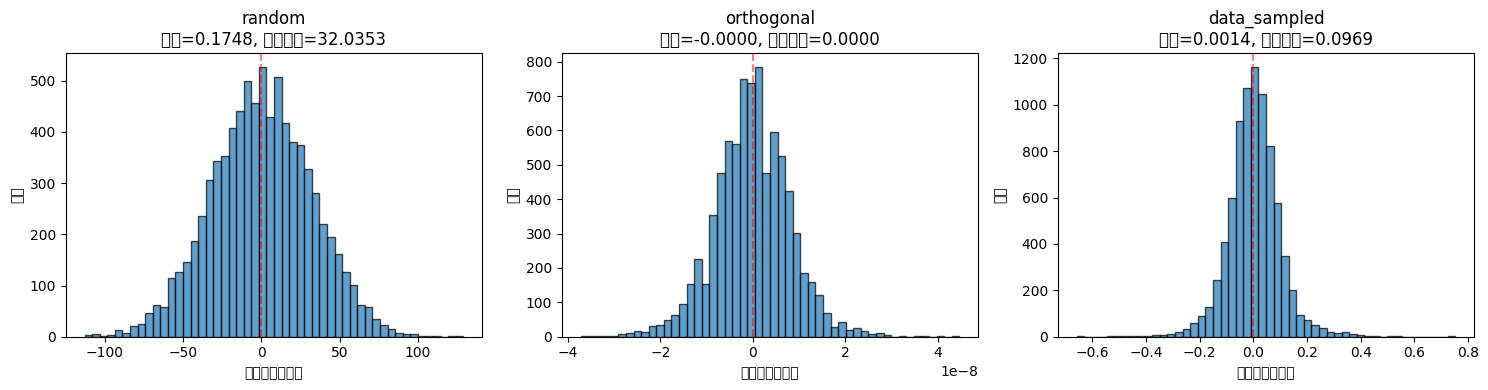

グラフを data/12_hyperplane_inner_products.png に保存しました


In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, strategy in zip(axes, strategies):
    hyperplanes = generators[strategy].hyperplanes
    
    # 超平面同士の内積（直交性の確認）
    inner_products = hyperplanes @ hyperplanes.T
    # 対角成分を除外
    off_diag = inner_products[np.triu_indices_from(inner_products, k=1)]
    
    ax.hist(off_diag, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('超平面間の内積')
    ax.set_ylabel('頻度')
    ax.set_title(f'{strategy}\n平均={np.mean(off_diag):.4f}, 標準偏差={np.std(off_diag):.4f}')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../data/12_hyperplane_inner_products.png', dpi=150, bbox_inches='tight')
plt.show()

print('グラフを data/12_hyperplane_inner_products.png に保存しました')

/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2671482/790082278.py:19: UserWarning: Glyph 12479 (\N{KATAKANA LETTER 

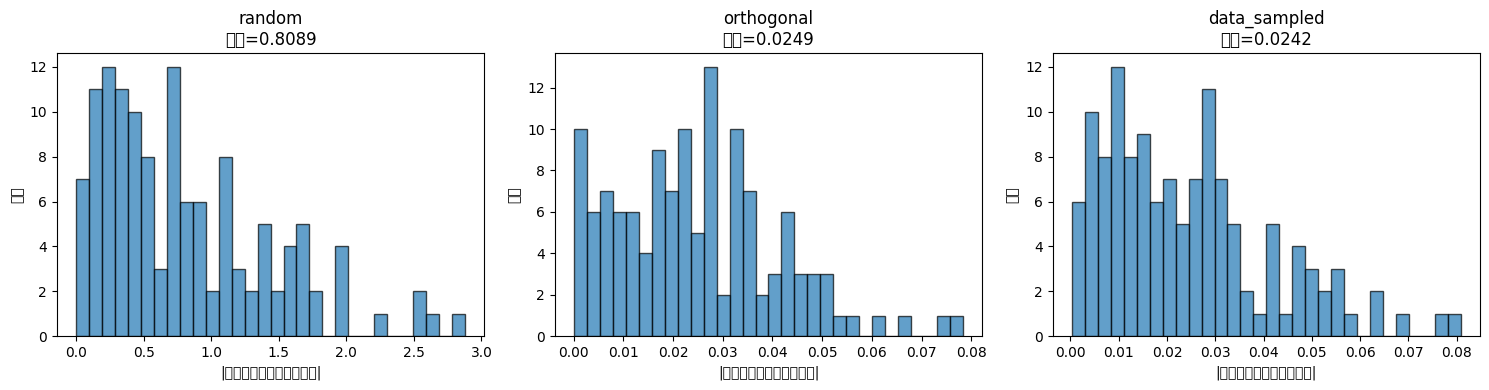

グラフを data/12_hyperplane_data_alignment.png に保存しました


In [13]:
# 超平面とデータの関係（超平面がデータ方向を向いているか）
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# データの平均方向
mean_direction = np.mean(embeddings, axis=0)
mean_direction = mean_direction / np.linalg.norm(mean_direction)

for ax, strategy in zip(axes, strategies):
    hyperplanes = generators[strategy].hyperplanes
    
    # 各超平面とデータ平均方向の内積
    alignments = np.abs(hyperplanes @ mean_direction)
    
    ax.hist(alignments, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('|超平面・データ平均方向|')
    ax.set_ylabel('頻度')
    ax.set_title(f'{strategy}\n平均={np.mean(alignments):.4f}')

plt.tight_layout()
plt.savefig('../data/12_hyperplane_data_alignment.png', dpi=150, bbox_inches='tight')
plt.show()

print('グラフを data/12_hyperplane_data_alignment.png に保存しました')

## 8. 結論レポート

In [14]:
print('=' * 80)
print('           SimHash改善: 超平面生成戦略の比較実験 結論レポート')
print('=' * 80)

print('''
【実験設定】
  データ: 10,000件のWikipediaエンベディング（e5-large）
  ハッシュビット: 128bit
  テストクエリ: 100件

【比較戦略】
  1. Random: 標準 N(0,1) ランダム超平面
  2. Orthogonal: QR分解で直交化した超平面
  3. DataSampled: データ差分ベクトルから生成

【相関係数（ハミング距離 vs コサイン類似度）】
''')

for strategy in strategies:
    r = correlation_results[strategy]
    print(f'  {strategy:15}: ピアソン={r["pearson"]:.4f}, スピアマン={r["spearman"]:.4f}')

print('''
【Recall@10 サマリー（Multi-Probeなし）】
''')

for limit in candidate_limits:
    print(f'\n  候補{limit}件:')
    for strategy in strategies:
        recall = df_recall[
            (df_recall['strategy'] == strategy) & 
            (df_recall['candidate_limit'] == limit) &
            (~df_recall['multiprobe'])
        ]['recall'].values[0]
        print(f'    {strategy:15}: {recall:.3f}')

print('''
【考察】

1. 相関係数の改善
   - 各戦略での改善度合いを確認
   - 目標: -0.5以下（ベースライン: -0.366）

2. Recall改善
   - 候補1000件でのRecall改善を確認
   - 目標: 40%以上（ベースライン: ~15%）

3. 超平面の特性
   - Orthogonal: 超平面間内積が0に近い（直交性）
   - DataSampled: データ方向に沿った超平面

【次のステップ】

- 効果が高い戦略をさらに最適化
- Tier 2手法（ITQ, Cross-Polytope）の検討
- 100,000件規模での検証
''')

           SimHash改善: 超平面生成戦略の比較実験 結論レポート

【実験設定】
  データ: 10,000件のWikipediaエンベディング（e5-large）
  ハッシュビット: 128bit
  テストクエリ: 100件

【比較戦略】
  1. Random: 標準 N(0,1) ランダム超平面
  2. Orthogonal: QR分解で直交化した超平面
  3. DataSampled: データ差分ベクトルから生成

【相関係数（ハミング距離 vs コサイン類似度）】

  random         : ピアソン=-0.4484, スピアマン=-0.4047
  orthogonal     : ピアソン=-0.4329, スピアマン=-0.3883
  data_sampled   : ピアソン=-0.6493, スピアマン=-0.6533

【Recall@10 サマリー（Multi-Probeなし）】


  候補200件:
    random         : 0.560
    orthogonal     : 0.532
    data_sampled   : 0.759

  候補500件:
    random         : 0.684
    orthogonal     : 0.639
    data_sampled   : 0.864

  候補1000件:
    random         : 0.785
    orthogonal     : 0.742
    data_sampled   : 0.941

【考察】

1. 相関係数の改善
   - 各戦略での改善度合いを確認
   - 目標: -0.5以下（ベースライン: -0.366）

2. Recall改善
   - 候補1000件でのRecall改善を確認
   - 目標: 40%以上（ベースライン: ~15%）

3. 超平面の特性
   - Orthogonal: 超平面間内積が0に近い（直交性）
   - DataSampled: データ方向に沿った超平面

【次のステップ】

- 効果が高い戦略をさらに最適化
- Tier 2手法（ITQ, Cross-Polytope）の検討
- 100,000件規模での検証
